### Methodoloty:
    1. Data acqusition
    2. Exploration Visualisation    
    3. Outlier Detection and Removal
    4. Data Preparation for forecasting
    5. Modeling
    6. Evaluation
    7. Deployment


In [2]:
#imports
import math
from math import sqrt
from dateutil import parser
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib as mpltl
from matplotlib import pyplot

from numpy import concatenate
import numpy  as np

import pandas as pd
from pandas import Series
from pandas import concat
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas.tools.plotting import lag_plot

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

%matplotlib inline

Using Theano backend.


# 2. Exploration Visualisation    

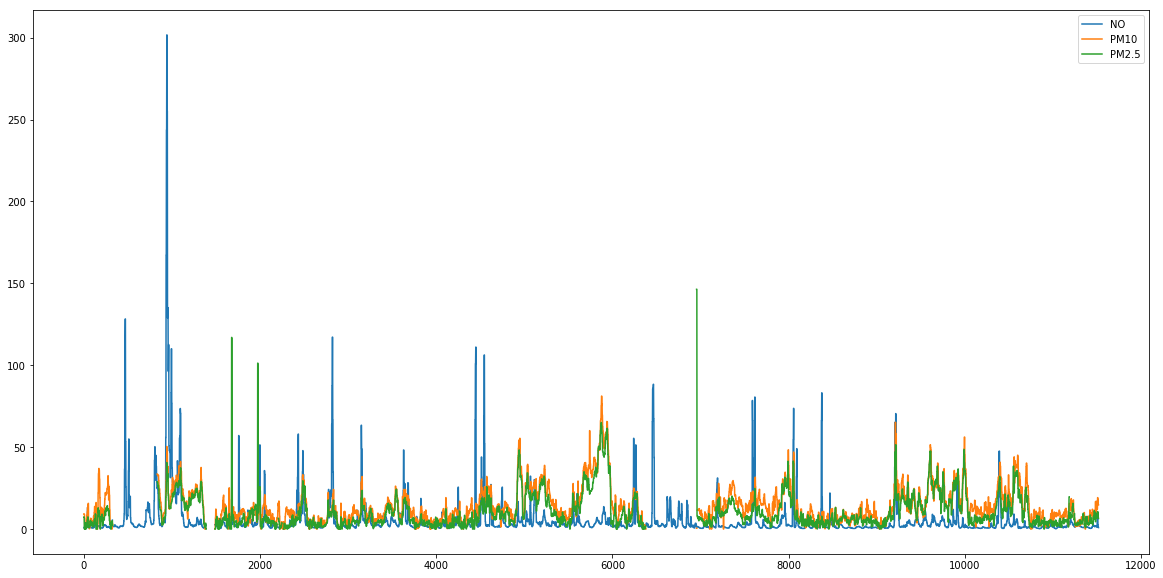

In [3]:
# import data
# data acquired from http://www.londonair.org.uk/LondonAir/API/ (Reading New town)
df = pd.read_csv('./data/simplified.csv')

# First Visualisation of Data
df.plot(figsize=(20,10))

# 3. Outlier Detection and Removal

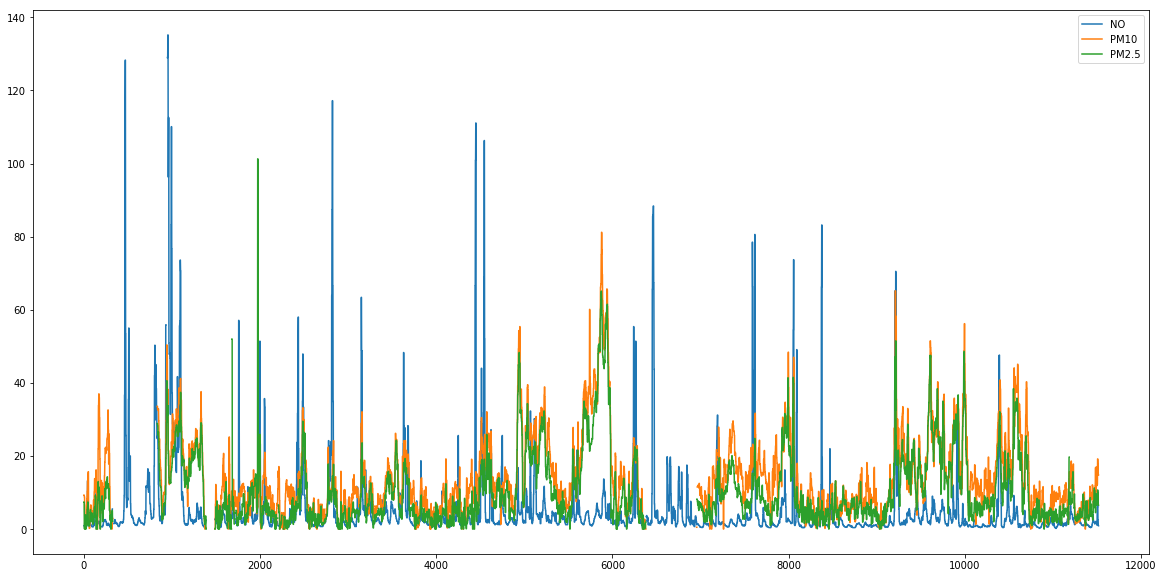

In [5]:
# Outlier removal and interpolation using (std)
df.loc[((np.abs(df['NO']-df['NO'].mean())>(10*df['NO'].std()))), 'NO'] = np.nan               
df.loc[:, 'NO'].interpolate(method='linear')        

df.loc[((np.abs(df['PM2.5']-df['PM2.5'].mean())>(10*df['PM2.5'].std()))), 'PM2.5'] = np.nan               
df.loc[:, 'PM2.5'].interpolate(method='linear')        

df.plot(figsize=(20,10))

# 4. Data Preparation for forecasting


In [6]:
# create train, test dataset
df_series = df.values
train_size = int(len(df_series) * 0.66)
train, test = df_series[0:train_size], df_series[train_size:len(df_series)]

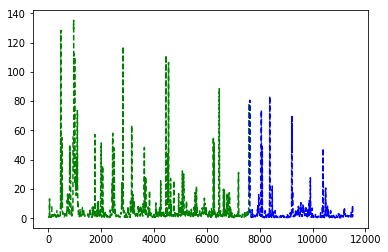

In [7]:
# set column nam,es
train_df = pd.DataFrame(train, columns = [['date','no','pm10', 'pm2.5']])
test_df = pd.DataFrame(test, columns = [['date','no','pm10', 'pm2.5']])

# convert date columns to proper datetime object
train_df['date'] = train_df['date'].astype('datetime64[ns]')
test_df['date'] = test_df['date'].astype('datetime64[ns]')

# remove multindex
train_df.columns = train_df.columns.get_level_values(0)
train_df.set_index('date', inplace=True)

# remove multindex
test_df.columns = test_df.columns.get_level_values(0)
test_df.set_index('date', inplace=True)

# create plot dataset for visualisation only for NO
test_plot = [None for i in list(train_df.values)] + [x for x in list(test_df['no'].values)]

# plot Train vs Test
plt.plot(train_df['no'].values, 'g--', test_plot, 'b--')


/Users/nskostas/Documents/GRN/Playground/python/grn-data-scripts/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  after removing the cwd from sys.path.


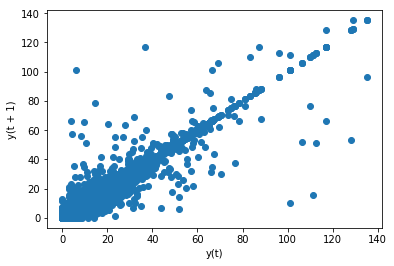

In [11]:
# lag plot of time series to check if there is correletion between t vs t-1
lag_plot(train_df)
plt.show()

# 5. Modeling

### 5.1 Persistence model (only PM10)

Test RMSE: 1.297


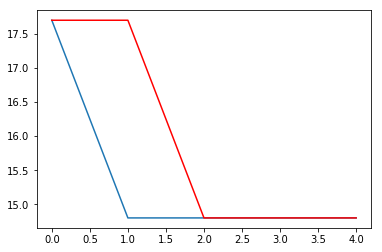

In [143]:
# evaluate a persistence model

# load dataset
values = df['PM10']
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-5], X[len(X)-5:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

### 5.3 Autoregressive model (only PM10)

Lag: 39
Test RMSE: 2.403


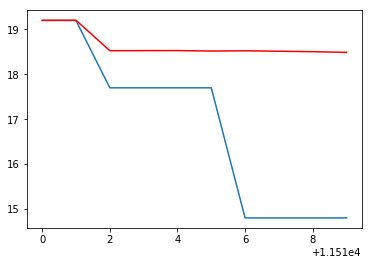

In [146]:
# create and evaluate a static autoregressive model

# load dataset
values = df['PM10'].interpolate('linear')
# split dataset
X = values
train, test = X[1:len(X)-10], X[len(X)-10:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
# print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
# 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## 6.3 Modeling using RNN - LSTM (NO, PM2.5, PM10)

In [67]:
# convert df to a supervised dataframe
# Link: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
    
df_temp = df[['NO', 'PM10', 'PM2.5']]

data = series_to_supervised(df_temp.values, 1, 1)
data.head(5)

   var1(t-1)  var2(t-1)  var3(t-1)  var1(t)  var2(t)  var3(t)
1        0.9        9.3        7.4      0.9      9.3      7.4
2        0.9        9.3        7.4      0.9      9.3      7.4
3        0.9        9.3        7.4      0.9      9.3      7.4
4        0.9        9.3        7.4      1.0      8.8      0.1
5        1.0        8.8        0.1      1.0      8.8      0.1


In [135]:
# Normalise values from 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data.values)

# split into train and test sets
values = scaled
print('values.shape', values.shape)
n = 7096 # 70% of total data
train = values[:n, :] # 70%
test = values[n:, :] # 30%
# split into input and outputs
train_X, train_y = train[:, :-3], train[:, 3:]
test_X, test_y = test[:, :-3], test[:, 3:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

values.shape (10167, 6)
(7096, 3) (7096, 3) (3071, 3) (3071, 3)
(7096, 1, 3) (7096, 3) (3071, 1, 3) (3071, 3)


Train on 7096 samples, validate on 3071 samples
Epoch 1/30
 - 128s - loss: 0.0656 - val_loss: 0.0494
Epoch 2/30
 - 128s - loss: 0.0500 - val_loss: 0.0388
Epoch 3/30
 - 127s - loss: 0.0378 - val_loss: 0.0269
Epoch 4/30
 - 127s - loss: 0.0250 - val_loss: 0.0201
Epoch 5/30
 - 128s - loss: 0.0185 - val_loss: 0.0177
Epoch 6/30
 - 128s - loss: 0.0159 - val_loss: 0.0173
Epoch 7/30
 - 127s - loss: 0.0139 - val_loss: 0.0150
Epoch 8/30
 - 127s - loss: 0.0131 - val_loss: 0.0143
Epoch 9/30
 - 127s - loss: 0.0124 - val_loss: 0.0134
Epoch 10/30
 - 127s - loss: 0.0117 - val_loss: 0.0126
Epoch 11/30
 - 127s - loss: 0.0110 - val_loss: 0.0109
Epoch 12/30
 - 128s - loss: 0.0102 - val_loss: 0.0098
Epoch 13/30
 - 127s - loss: 0.0095 - val_loss: 0.0091
Epoch 14/30
 - 128s - loss: 0.0089 - val_loss: 0.0084
Epoch 15/30
 - 127s - loss: 0.0085 - val_loss: 0.0090
Epoch 16/30
 - 128s - loss: 0.0085 - val_loss: 0.0074
Epoch 17/30
 - 127s - loss: 0.0074 - val_loss: 0.0076
Epoch 18/30
 - 128s - loss: 0.0074 - val_lo

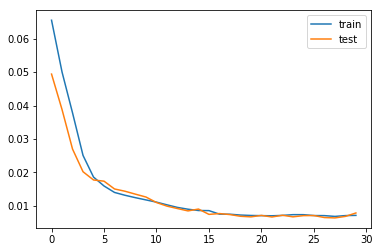

In [137]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# 6. Evaluation

In [140]:
# make a prediction
test_X, test_y = test[:, :-3], test[:, 3:]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

yhat = model.predict(test_X)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 3))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.014


# 7. Deployment

In [141]:
# serialize model to JSON
model_json = model.to_json()
with open("./model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./model/model.h5")
print("Saved model to disk")

Saved model to disk
